In [1]:
# Import these packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom as pdicom
import cv2

In [2]:
## Load the original csv as labels_df
pth=''
cs1= pd.read_csv(pth+'calc_case_description_test_set.csv',index_col=False)
cs2= pd.read_csv(pth+'calc_case_description_train_set.csv',index_col=False)
cs3=pd.concat([cs1,cs2])

# There is a trailing line break at the end of each image's path which is removed here
cs3['ROI mask file path']=pth+'DOI/'+cs3['ROI mask file path']

# Create empty dataframe first
labels_df=pd.DataFrame()

# Read & Display images
for x in range(cs3.shape[0]):
    row=cs3.iloc[x]
    imgloc=row['ROI mask file path']
    try:
        img=pdicom.read_file(imgloc,force=True)
        labels_df=labels_df.append(row,ignore_index=True) 
    except:
        pass
print('# of Images present:',labels_df.shape[0])
print('# of Images missing:',cs3.shape[0]-labels_df.shape[0])
print('Total',cs3.shape[0])

# of Images present: 14
# of Images missing: 1858
Total 1872


In [ ]:
# Create new CSV with the images stored with it as newcsv and stored as newcsv.pkl
from skimage.transform import rotate

def preprocess_image(path):
    img=pdicom.read_file(path,force=True)
    imgpix=img.pixel_array

    # Scaling 16-bit pixel to 8-bits
    imgpix=((imgpix/65535)*255).astype(np.uint8)


    # Resizing image to (224,224)
    imgpix=cv2.resize(imgpix,(224,224))

    #Contrast enhancement
    equ = cv2.equalizeHist(imgpix)
    
    #dilation
    k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 5))
    k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
    dil= cv2.dilate(equ,k1,iterations = 1)
     #store it back in the dicom image
    img.pixel_array=dil
    return dil

newcsv=pd.DataFrame()
ROTATE_LEVELS=[0,90,180,270]
for x in range(labels_df.shape[0]):
    row=labels_df.iloc[x]
    imgloc=row['ROI mask file path']
    img=preprocess_image(imgloc)
    for y in ROTATE_LEVELS:
        if y:
            imgpix=rotate(img,y,preserve_range=True).astype(np.uint8)
        else:
            imgpix=img
        row['pixel_array']=imgpix
#        print(len(np.fromstring(row['pixel_array'],dtype=np.uint8)))
        newcsv=newcsv.append(row,ignore_index=True)

# Saving the dataframe as a pickle file
newcsv.to_pickle('new.pkl')
print("Done!")

In [103]:
# Load the new csv
newcsv=pd.read_pickle('newcsv.pkl')

In [ ]:
# Reading the image
img=pdicom.read_file(li[-5],force=True)
imgpix=img.pixel_array

# Scaling 16-bit pixel to 8-bits
imgpix=((imgpix/65535)*255).astype(np.uint8)

# Resizing image to (224,224)
imgpix=cv2.resize(imgpix,(224,224))

#Contrast enhancement
equ = cv2.equalizeHist(imgpix)

#dilation
k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 5))
k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
dil= cv2.dilate(equ,k1,iterations = 1)

# Stacking all the images together for comparison
res = np.hstack((imgpix,equ,dil)) #stacking images side-by-side
plt.imshow(res)

In [ ]:
# Trying out different kernel shapes
k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5))
k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5))
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 5))
k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
print(k1,k2,k3,k4,sep="\n")

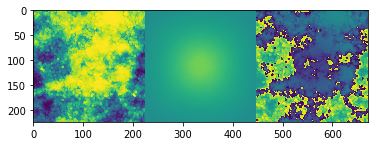

In [104]:
hh=newcsv.pixel_array
img=hh[0]

#print('Image Array\n',img)
avg=hh.apply(lambda x:x.astype(np.uint64)).mean().astype(np.uint8)

#print('Mean Pixel Values from the dataset\n',avg)
res=(img-avg).astype(np.uint8)

#print('Image Array after subtracting mean',res)
plt.imshow(np.hstack((img,avg,res)))

In [106]:
avg

array([[118, 120, 121, ..., 121, 120, 117],
       [120, 122, 123, ..., 123, 122, 120],
       [121, 123, 124, ..., 124, 123, 121],
       ...,
       [121, 123, 124, ..., 124, 123, 121],
       [120, 122, 123, ..., 123, 122, 120],
       [118, 120, 121, ..., 121, 120, 117]], dtype=uint8)